# Sobol' indices by simulation


In the previous example we have seen how to estimate Sobol' indices with a fixed-sized design of experiment.
Now we will see that there is also a simulation algorithm that allows to use as many samples as needed to reach a given precision, or until a time limit is hit or the user cancels the simulation.

We consider a cantilever beam defined by its Young’s modulus $E$, its length $L$ and its section modulus $I$. One end of the cantilever beam is built in a wall and we apply a concentrated bending load $F$ at the other end of the beam, resulting in a deviation $Y$. 

<img src="beam.png" width="200">

**Inputs**

* $E$ : Young modulus (Pa), Beta(r = 0.9, t = 3.5, a = $2.5\times 10^7$, $b = 5\times 10^7$)
* $F$ : Loading (N), Lognormal($\mu_F=30 \times 10^3$, $\sigma_F=9\times 10^3$, shift=$15\times 10^3$)
* $L$ : Length of beam (cm), Uniform(min=250.0, max= 260.0)
* $I$ : Moment of inertia (cm^4), Beta(r = 2.5, t = 4.0, a = 310, b = 450).

In the previous table $\mu_F=E(F)$ and $\sigma_F=\sqrt{V(F)}$ are the mean and the standard deviation of $F$.

We assume that the random variables E, F, L and I are dependent and associated with a gaussian copula which correlation matrix is :
$$
R = 
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & -0.2 \\
0 & 0 & -0.2 & 1
\end{pmatrix}
$$

In other words, we consider that the variables L and I are negatively correlated : when the length L increases, the moment of intertia I decreases.

**Output**

The vertical displacement at free end of the cantilever beam is:
$$
Y  = \dfrac{F\, L^3}{3 \, E \, I}
$$


## Definition of the model

In [21]:
import openturns as ot

We define the symbolic function which evaluates the output Y depending on the inputs E, F, L and I.

In [22]:
model = ot.SymbolicFunction(["E", "F", "L", "I"], ["F*L^3/(3*E*I)"])

Then we define the distribution of the input random vector. 

In [23]:
# Young's modulus E
E = ot.Beta(0.9, 3.5, 2.5e7, 5.0e7) # in N/m^2
E.setDescription("E")
# Load F
F = ot.LogNormal() # in N
F.setParameter(ot.LogNormalMuSigma()([30.e3, 9e3, 15.e3]))
F.setDescription("F")
# Length L
L = ot.Uniform(250., 260.) # in cm
L.setDescription("L")
# Moment of inertia I
I = ot.Beta(2.5, 4, 310, 450) # in cm^4
I.setDescription("I")

Finally, we define the dependency using a `NormalCopula`.

In [24]:
distribution = ot.ComposedDistribution([E, F, L, I])

## Create algorithm

First we select which estimator to use:

In [25]:
estimator = ot.SaltelliSensitivityAlgorithm()
estimator.setUseAsymptoticDistribution(True)

Then the simulation algorithm is configured:

In [26]:
algo = ot.SobolSimulationAlgorithm(distribution, model, estimator)
algo.setMaximumOuterSampling(250) # number of iterations
algo.setBlockSize(100) # size of Sobol experiment at each iteration
algo.setBatchSize(4) # number of points evaluated simultaneously
algo.setIndexQuantileLevel(0.05) # alpha: cirteria checks whether CIs are small enough
algo.setIndexQuantileEpsilon(1e-2) # epsilon: critera checks whether CIs are tight enough
algo.run()

## Results

In [27]:
result = algo.getResult()
print("first order indices:", result.getFirstOrderIndicesEstimate())
print("total order indices:", result.getTotalOrderIndicesEstimate())

first order indices: [0.154081,0.872087,0.0122877,0.0433801]
total order indices: [0.16743,0.795477,0.0124454,0.045178]


Normal(mu = [0.16743,0.795477,0.0124454,0.045178], sigma = [0.0068919,0.00950876,0.00204324,0.0038844], R = [[ 1 0 0 0 ]
 [ 0 1 0 0 ]
 [ 0 0 1 0 ]
 [ 0 0 0 1 ]])


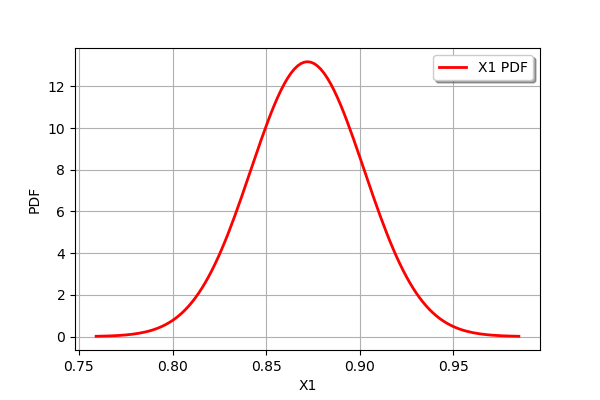

In [37]:
# distribution of X1 first order indices:
print(result.getTotalOrderIndicesDistribution())
result.getFirstOrderIndicesDistribution().getMarginal(1).drawPDF()

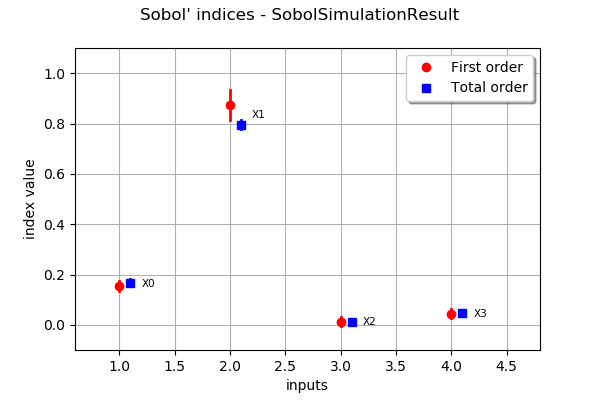

In [33]:
# plot of estimates and confidence intervals
result.draw()